In [11]:
!jupyter labextension update --all

(Deprecated) Updating extensions with the jupyter labextension update command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/Users/aizotov/mambaforge/envs/fastai-lab/lib/python3.11/site-packages/jupyterlab/debuglog.py:56: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/Users/aizotov/mambaforge/envs/fastai-lab/lib/python3.11/site-packages/jupyterlab/debuglog.py:57: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
/Users/aizotov/mambaforge/envs/fastai-lab/lib/python3.11/site-packages/jupyterlab/debuglog.py:58: UserWarning: See the log file for details: /var/fold

In [1]:
%%time

from fastbook import Path
from fastbook import search_images_ddg
from fastai.vision.utils import download_images

path = Path('images')
bear_types = 'grizzly','black','teddy'

if not path.exists():
    path.mkdir(parents=True)
    for o in bear_types:
        print(f"downloading images: {o}")
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear', 150)
        download_images(dest, urls=results)

CPU times: user 3.55 s, sys: 2.1 s, total: 5.65 s
Wall time: 2.04 s


In [2]:
# Delete broken images

from fastai.vision.utils import verify_images
from fastai.data.transforms import get_image_files

fns = get_image_files(path)

failed = verify_images(fns)
if len(failed) > 0:
    failed.map(Path.unlink)
    print(f'Removed {len(failed)} corrupted images')

In [3]:
# Delete images with transparency channel

import os
from fastai.vision.core import Image
from fastcore.foundation import L 

def verify_no_alpha(image_files):
    alpha_image_paths = L()
    modes = {}
    for file in image_files:
        try:
            with Image.open(file) as img:
                if img.mode not in modes:
                    modes[img.mode] = 0
                modes[img.mode] += 1
                
                if img.mode in ('RGBA', 'P'):
                    print(f'alpha channel {file}')
                    alpha_image_paths.append(file)
                elif not img.format == 'JPEG':
                    print(f'not jpeg format {file}')
                    alpha_image_paths.append(file)
                elif not file.name.lower().endswith(('.jpg', '.jpeg')):
                    printf(f'not .jpg or .jpeg')
                    alpha_image_paths.append(file)
        except Exception as e:
            print(f'Error processing {entry} : {path} : {e}')
    return alpha_image_paths, modes

fns = get_image_files(path)
alpha, _ = verify_no_alpha(fns)
if len(alpha) > 0:
    alpha.map(Path.unlink)
    print(f'Removed {len(alpha)} images with alpha channel')

In [4]:
from fastai.data.block import DataBlock, CategoryBlock
from fastai.vision.data import ImageBlock
from fastai.data.transforms import RandomSplitter, parent_label
from fastai.vision.augment import Resize

bears = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

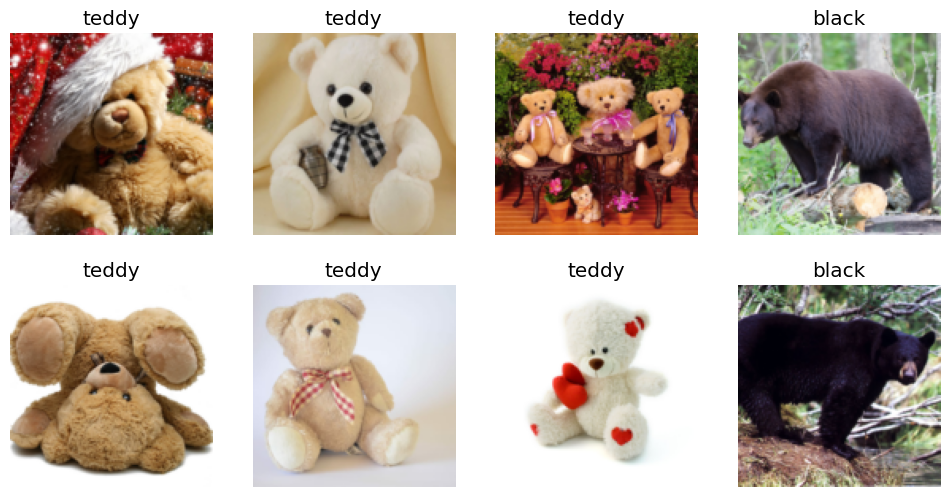

In [5]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8)

/Users/aizotov/mambaforge/envs/fastai-lab/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343668887/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  ret = func(*args, **kwargs)


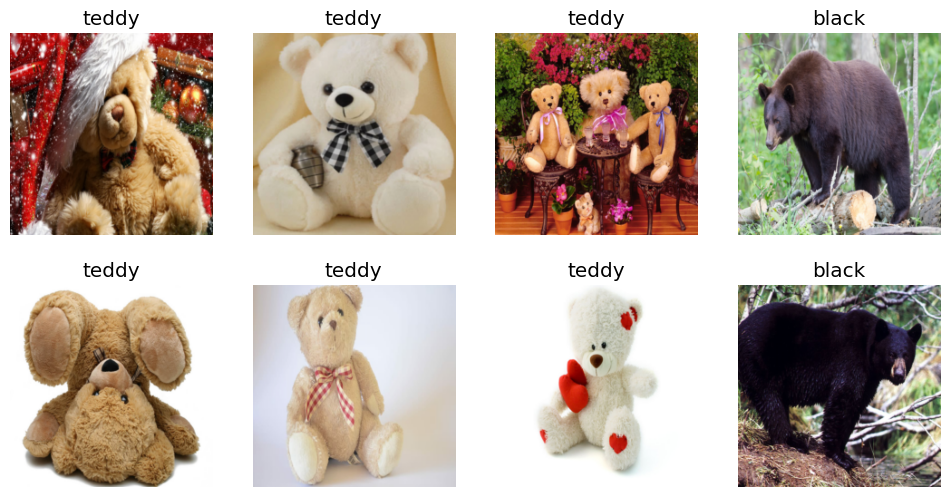

In [6]:
from fastai.vision.augment import RandomResizedCrop, aug_transforms

bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8)

In [7]:
from fastai.vision.learner import vision_learner
from fastai.vision.models import resnet18
from fastai.metrics import error_rate

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/Users/aizotov/mambaforge/envs/fastai-lab/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/aizotov/mambaforge/envs/fastai-lab/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.343544,0.260679,0.112676,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.326731,0.160623,0.042254,00:11
1,0.265582,0.169064,0.042254,00:11
2,0.199207,0.190256,0.042254,00:11
3,0.165195,0.196747,0.042254,00:11


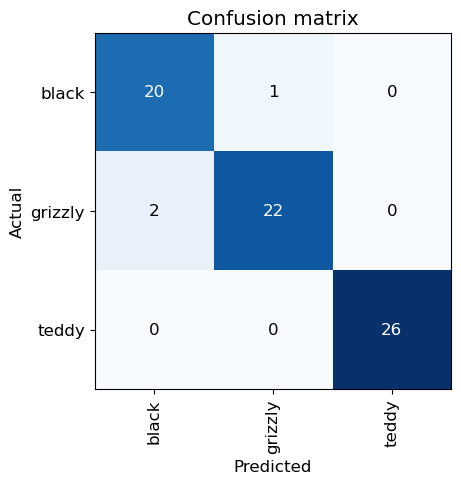

In [8]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

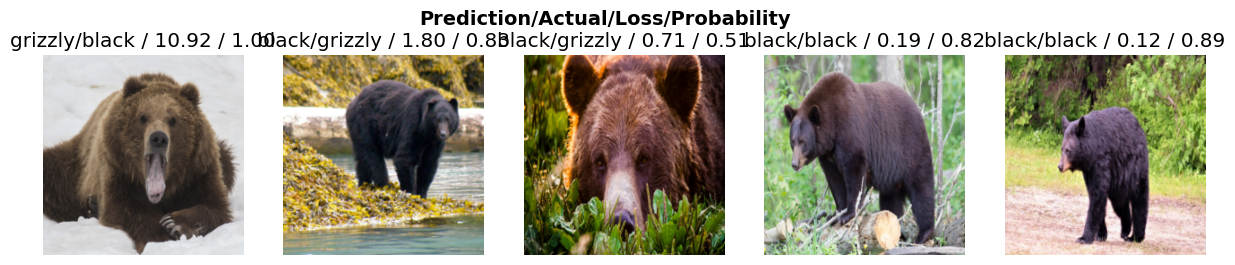

In [9]:
interp.plot_top_losses(5, nrows=1)

In [10]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner